In [1]:
general_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
results_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models'
data_suffix = 'Valencia'
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import phagehostlearn_features as phlf
import phagehostlearn_utils as phlu
from sklearn.metrics import roc_auc_score, auc, roc_curve

In [2]:
# load the data
matrix = np.loadtxt(general_path+'/all_loci_score_matrix.txt', delimiter='\t')
rbp_embeddings_path = general_path+'/esm2_embeddings_rbp'+data_suffix+'.csv'
loci_embeddings_path = general_path+'/esm2_embeddings_loci'+data_suffix+'.csv'
features_esm2, labels, groups_loci, groups_phage = phlf.construct_feature_matrices(general_path, data_suffix, loci_embeddings_path, rbp_embeddings_path)

Dimensions match? True


In [4]:
import pandas as pd
import numpy as np
import json
import random

# prep the data
interactions1 = general_path+'/klebsiella_phage_host_interactions.xlsx'
interactions2 = general_path+'/klebsiella_interactions_part2.xlsx' # for part 1 NO SUGGESTIONS POSSIBLE -> ALL UNIQUE K-TYPES
matrix1 = pd.read_excel(interactions1, index_col=0, header=0)
matrix2 = pd.read_excel(interactions2, index_col=0, header=0)
locipath = general_path+'/LocibaseValencia.json'
seros = pd.read_csv(general_path+'/serotypesValencia.csv')
with open(locipath) as f:
    locibase = json.load(f)

# do the informed approach
hits = {i: 0 for i in range(1, 51)}
total = 0
# --------------------
# MATRIX 1
# --------------------
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]
    
# phages sorted by broad-spec
sorted_phages = matrix1.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix1.index.values)
no_genome = ['K2', 'K21', 'K23', 'K27', 'K28', 'K40', 'K45', 'K48', 'K52', 'K53', 'K67', 'K69', 'K70', 'K71', 'K72']
rownames = [str(i) for i in rownames if i not in no_genome]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]
        
# iterate over all accessions in matrix1
for i, accession in enumerate(rownames):
    # only compute hit ratio when we can find something
    if sum(matrix1.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix1 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix1.columns[matrix1.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix1[x].sum(), reverse=True)
        
        total += 1
        for k in range(1, 51):
            # approach 1: if we dont have enough suggestions, pick extra at random from total pool available
            # approach 2: now, we supplement them with the sorted phages by broad-spectrum, not random!
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]

            #suggested = random.sample(phage_suggestions, k)
            if any([matrix1.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1
                
# --------------------
# MATRIX 2
# --------------------
hits2 = {i: 0 for i in range(1, 51)}
total2 = 0
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]
    
sorted_phages = matrix2.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix2.index.values)
rownames = [str(i) for i in rownames]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]

# iterate over all accessions in matrix2
for i, accession in enumerate(matrix2.index.values):
    # only compute hit ratio when we can find something
    if sum(matrix2.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix2 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix2.columns[matrix2.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix2[x].sum(), reverse=True)

        total += 1
        total2 += 1
        for k in range(1, 51):
            # if we dont have enough suggestions, pick extra at random from the total pool
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]
            
            if any([matrix2.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1
                hits2[k] += 1

informed_hitratio = {k: v/total for k, v in hits.items()}
informed_hitratio2 = {k: v/total2 for k, v in hits2.items()}

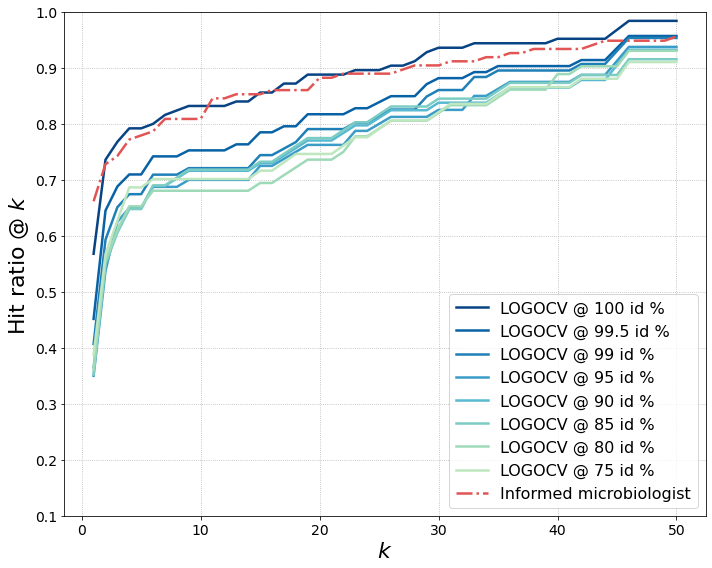

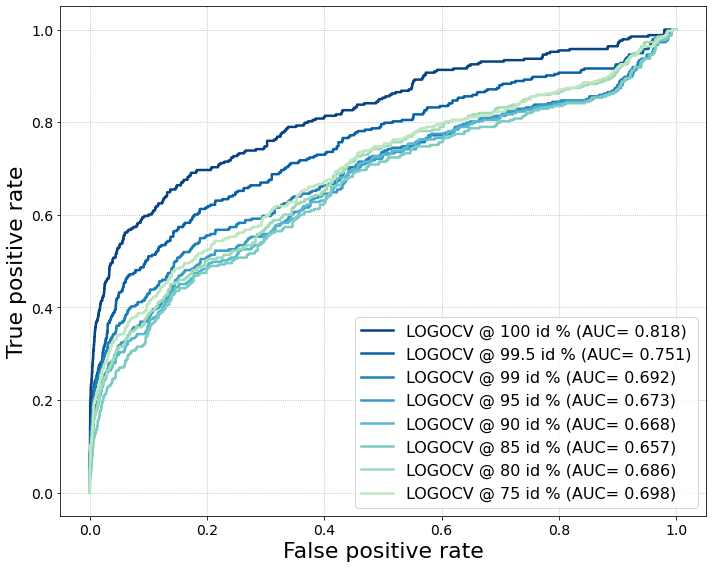

In [10]:
# make the plots
fig1, ax1 = plt.subplots(figsize=(10,8))
fig2, ax2 = plt.subplots(figsize=(10,8))
thresholds = [1.0, 0.995, 0.99, 0.95, 0.9, 0.85, 0.8, 0.75]
tstr = ['100', '99.5', '99', '95', '90', '85', '80', '75']
colors = plt.cm.GnBu(np.linspace(0.99,0.3,len(thresholds)))
ks = np.linspace(1, 50, 50)
for i, thres in enumerate(thresholds):
    # make new_groups if needed
    group_i = 0
    new_groups = [np.nan] * len(groups_loci)
    for j in range(matrix.shape[0]):
        cluster = np.where(matrix[j,:] >= thres)[0]
        oldgroups_i = [k for k, x in enumerate(groups_loci) if x in cluster]
        if np.isnan(new_groups[groups_loci.index(j)]):
            for ogi in oldgroups_i:
                new_groups[ogi] = group_i
            group_i += 1
    
    # read results
    with open(results_path+'/v3.4/combined_logocv_results_v34_'+tstr[i]+'.pickle', 'rb') as f:
        logo_results = pickle.load(f)
    scores_lan = logo_results['scores_language']
    label_list = logo_results['labels']

    # compute performance
    rqueries_lan = []
    for l in range(len(set(new_groups))):
        score_lan = scores_lan[l]
        y_test = label_list[l]
        try:
            roc_auc = roc_auc_score(y_test, score_lan)
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
        except:
            pass

    # plot HR @ K
    hits_lan = [phlu.hitratio(rqueries_lan, int(k)) for k in ks]
    ax1.plot(ks, hits_lan, c=colors[i], linewidth=2.5, label='LOGOCV @ '+tstr[i]+' id %')    

    # plot AUC
    labels = np.concatenate(label_list).ravel()
    scoreslr = np.concatenate(scores_lan).ravel()
    fpr, tpr, thrs = roc_curve(labels, scoreslr)
    rauclr = round(auc(fpr, tpr), 3)
    ax2.plot(fpr, tpr, c=colors[i], linewidth=2.5, label='LOGOCV @ '+tstr[i]+' id % (AUC= '+str(rauclr)+')')

ax1.plot(ks, list(informed_hitratio.values()), c='#E15554', linewidth=2.5, ls='-.', label='Informed microbiologist')
ax1.set_xlabel('$\it{k}$', size=22)
ax1.set_ylabel('Hit ratio @ $\it{k}$', size=22)
ax1.set_ylim(0.1, 1)
ax1.legend(loc=4, prop={'size': 16})
ax1.grid(True, linestyle=':')
ax1.yaxis.set_tick_params(labelsize = 14)
ax1.xaxis.set_tick_params(labelsize = 14)
fig1.tight_layout()
fig1.savefig(results_path+'/v3.4/logocv_hitratio_complete.png', dpi=400)
fig1.savefig(results_path+'/v3.4/logocv_hitratio_complete_svg.svg', format='svg', dpi=400)

ax2.set_xlabel('False positive rate', size=22)
ax2.set_ylabel('True positive rate', size=22)
ax2.legend(loc=4, prop={'size': 16})
ax2.grid(True, linestyle=':')
ax2.yaxis.set_tick_params(labelsize = 14)
ax2.xaxis.set_tick_params(labelsize = 14)
fig2.tight_layout()
fig2.savefig(results_path+'/v3.4/logocv_ROC_complete.png', dpi=400)
fig2.savefig(results_path+'/v3.4/logocv_ROC_complete_svg.svg', format='svg', dpi=400)